# Introduction to Keras

## 1. Classifying bank complaints

### 1.1 Loading the data

#### 1.1.1 Look at the data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer

df = pd.read_csv('Bank_complaints.csv')
df.head()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


In [2]:
df = df.sample(10000)

In [3]:
df.index = range(10000)

In [4]:
product = df["Product"]

There are 7 types of complaints

In [5]:
product.value_counts()

Student loan                   1891
Credit card                    1634
Consumer Loan                  1546
Mortgage                       1377
Bank account or service        1338
Credit reporting               1174
Checking or savings account    1040
Name: Product, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Product                         10000 non-null object
Consumer complaint narrative    10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB


In [7]:
complaints = df["Consumer complaint narrative"]

### 1.1.2 One-hot encoding of the complaints

Only keep 2,000 most common words and use one-hot encoding

In [8]:
tokenizer = Tokenizer(num_words=2000)

In [9]:
tokenizer.fit_on_texts(complaints)

In [10]:
sequences = tokenizer.texts_to_sequences(complaints)

In [11]:
one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary')

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 21442 unique tokens.


In [12]:
#word_index.items()

In [13]:
np.shape(one_hot_results)

(10000, 2000)

Decode the review again, can be done as follows:

word_index stores the mapping from the label number to the actual word.

In [14]:
reverse_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_index.get(i) for i in sequences[19]])

In [15]:
decoded_review

"citi increased my interest rate in xxxx from 15 to 29 and never told me about it when i found out about it online 7 months later they when i asked for information and finally lied about whether i could close my account after initially and denying that my interest rate was a default rate they finally admitted it was but would not advise of the default when i reviewed every statement of mine since the rate increase i found absolutely no delinquency i told them i wanted to close my account citi said i would lose over xxxx miles on xxxx xxxx if i did i called xxxx the next day and the woman at xxxx informed be that citi was wrong and that they tell that ''"

In [16]:
complaints[19]

'CITI surreptitiously increased my interest rate in XXXX from 15 % to 29 % and never told me about it. When I found out about it online 7 months later, they stalled when I asked for information and finally lied about whether I could close my account. After stalling initially and denying that my interest rate was a default rate, they finally admitted it was but would not advise of the default. When I reviewed every statement of mine since the rate increase, I found absolutely no delinquency. I told them I wanted to close my account. Citi said I would lose over XXXX miles on XXXX XXXX if I did. I called XXXX the next day, and the woman at XXXX informed be that Citi was wrong and " that they tell everybody that. \'\' Extraordinarily infuriating.'

You can see that some words dropped, but hopefully we caught the ones that have the useful distincive characteristics!

### 1.1.3 convert the products to numerical categories

In [17]:
le = preprocessing.LabelEncoder()

In [18]:
le.fit(product)

LabelEncoder()

In [19]:
list(le.classes_)

['Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit reporting',
 'Mortgage',
 'Student loan']

In [20]:
product_cat = le.transform(product) 

In [21]:
list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4]))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Bank account or service',
 'Checking or savings account',
 'Credit card',
 'Credit card',
 'Bank account or service',
 'Student loan',
 'Credit reporting']

In [22]:
product_cat

array([2, 1, 6, ..., 6, 5, 5])

In [23]:
product_onehot = to_categorical(product_cat)

In [24]:
np.shape(product_onehot)

(10000, 7)

### 1.1.4 Train - test split

In [29]:
import random
random.seed(123)
test_index = random.sample(range(1,10000), 1500)

Create a test and a training set

In [30]:
test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)

In [31]:
label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

In [32]:
print(np.shape(label_test))
print(np.shape(label_train))
print(np.shape(test))
print(np.shape(train))

(1500, 7)
(8500, 7)
(1500, 2000)
(8500, 2000)


# 1.2 Building the network

Let's build a fully connected (Dense) layer network with relu activations in Keras. You can do this using: `Dense(16, activation='relu')`.

In this examples, use 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because we are dealing with a multiclass problem (classifying the complaints into 7 ), we use a use a softmax classifyer in order to output 7 class probabilities per case.

In [34]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

### 1.3 Compiling the model and look at the results

In [35]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 20 epochs in mini-batches of 512 samples.

In [57]:
history = model.fit(train,
                    label_train,
                    epochs=70,
                    batch_size=256)

Epoch 1/70
8500/8500 [==============================] - 0s 49us/step - loss: 0.3917 - acc: 0.8699
Epoch 2/70
8500/8500 [==============================] - 0s 43us/step - loss: 0.3891 - acc: 0.8701
Epoch 3/70
8500/8500 [==============================] - 0s 46us/step - loss: 0.3868 - acc: 0.8701
Epoch 4/70
8500/8500 [==============================] - 0s 45us/step - loss: 0.3840 - acc: 0.8739
Epoch 5/70
8500/8500 [==============================] - 0s 50us/step - loss: 0.3816 - acc: 0.8746
Epoch 6/70
8500/8500 [==============================] - 0s 52us/step - loss: 0.3790 - acc: 0.8760
Epoch 7/70
8500/8500 [==============================] - 0s 58us/step - loss: 0.3765 - acc: 0.8754
Epoch 8/70
8500/8500 [==============================] - 1s 62us/step - loss: 0.3740 - acc: 0.8772
Epoch 9/70
8500/8500 [==============================] - 0s 58us/step - loss: 0.3710 - acc: 0.8788
Epoch 10/70
8500/8500 [==============================] - 1s 62us/step - loss: 0.3690 - acc: 0.8796
Epoch 11/70
8500/85

The dictionary `history` contains four entries: one per metric that was being monitored during training and during validation.

In [58]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc'])

### 1.5 Plot the results

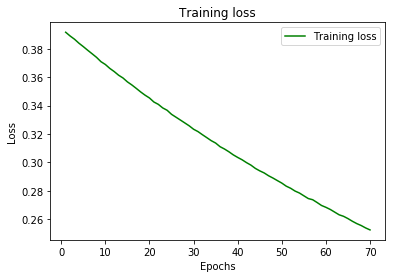

In [59]:
plt.clf()

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

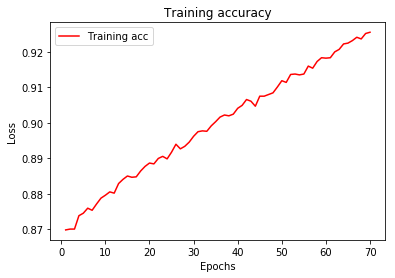

In [60]:
plt.clf()

acc_values = history_dict['acc'] 

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It seems like we could just keep on going and accuracy would go up!

This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. What you’re seeing is overfitting: after the  third epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

### 1.6 Make predictions

In [61]:
model.predict(test)

array([[9.9835312e-04, 2.3642726e-06, 2.9615771e-02, ..., 4.5119110e-02,
        9.2355657e-01, 5.4153774e-05],
       [3.7688136e-04, 3.5481538e-05, 3.8120907e-02, ..., 1.8955946e-03,
        2.8981101e-03, 9.3801749e-01],
       [9.3856430e-01, 5.7524633e-02, 9.5641335e-05, ..., 8.0371807e-05,
        3.4486435e-03, 7.8324192e-06],
       ...,
       [8.7086810e-04, 7.3219737e-04, 2.3825239e-02, ..., 2.3967910e-01,
        7.2297448e-01, 6.2916107e-03],
       [7.6923378e-02, 7.5645950e-03, 8.2891276e-03, ..., 2.7100258e-03,
        4.7434196e-03, 3.9393110e-03],
       [2.9717387e-12, 2.8353500e-12, 7.1020473e-10, ..., 2.7622847e-11,
        1.0000000e+00, 5.8407257e-10]], dtype=float32)

In [62]:
results_train = model.evaluate(train, label_train)

8500/8500 [==============================] - 0s 52us/step


In [63]:
results_test = model.evaluate(test, label_test)

1500/1500 [==============================] - 0s 62us/step


In [64]:
results_train

[0.250485277372248, 0.9262352940615486]

In [65]:
results_test

[0.6679157531261444, 0.7680000001589458]

We can see that the training set results are really good (a 92.6% classification accuracy!), but the test set results lag behind. In the next lab. We'll talk a little more about this in the next lecture, and will discuss how we can get better test set results as well!

# SOURCES

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb

https://catalog.data.gov/dataset/consumer-complaint-database